# Prepare C4 dataset and Pre-train Falcon model using PyTorch Fully Sharded Data Parallelism (FSDP)

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/training|distributed_training|pytorch|data_parallel|fully_sharded_data_parallel|falcon|smddp_fsdp_example.ipynb)

---

In this tutorial, we will show how to train or fine-tune [Falcon-7B-instruct](https://huggingface.co/tiiuae/falcon-7b-instruct) on the [GLUE/SST2](https://huggingface.co/datasets/glue/viewer/sst2/train) dataset.  We will use 2 p4d.24xlarge instances, which come with 8 NVIDIA A100 40GB GPUs along with the PyTorch Fully Sharded Data Parallelism (FSDP) technique to efficiently train this large model with limited GPU memory.  

To accelerate training speed, we will also use the **SageMaker Distributed Data Parallel Library (SMDDP)** which speeds up GPU communication across P4d instances during sharded data parallel training.  

## Files
* `scripts/data.py` - Script to download, tokenize and group into a specific sequence length.
* `scripts/train.py` - The entry point for the training script where we initialize the SMDDP library.
* `scripts/utils.py` - Helper script for defining dataloaders
* `scripts/requirements.txt` - List of dependencies required for this example to train on SageMaker

*Note: The SMDDP library for accelerated sharded data parallel training is compatible with deep learning containers from PyTorch 2.0 onwards.  Ensure you are using PyTorch >=2.0 for this example.*

### How optimized GPU communication is enabled with SMDDP in FSDP
Enabling the SMDDP library in an existing FSDP training script is seamless.  As shown in `train.py`, the only code modifications required are:
* Importing the library: `import smdistributed.dataparallel.torch.torch_smddp`
* Creating the process group with `"smddp"` backend: `torch.distributed.init_process_group("smddp")`

## 1. Getting started

First, we'll install some dependencies in our current environment

If you are going to use Sagemaker in a local environment, you need access to an IAM Role with the required permissions for Sagemaker. You can find more about it [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html).



In [ ]:
import sagemaker, boto3, datetime, time

from sagemaker.pytorch import PyTorch

    sagemaker_session = sagemaker.Session()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sagemaker_session = sagemaker.Session()
print(f"sagemaker role arn: {role}")
print(f"sagemaker session region: {sagemaker_session.boto_region_name}")

## 2. Load and prepare the dataset

As the base dataset, we will use the C4 (https://huggingface.co/datasets/allenai/c4) dataset, but before training the model, we need to preprocess the data. We will create chunks of `2048` tokens ([model max length](https://huggingface.co/EleutherAI/gpt-neox-20b)) to avoid unnecessary padding and computing. 

The first step is to prepare batches of dataset splits from Hugging Face c4 dataset.

In [ ]:
model_id = "tiiuae/falcon-7b"

In [ ]:
def create_worker_range(num_of_hf_splits, num_of_workers):
    """
    Create a list of worker batches for processing a dataset.

    Args:
        num_of_hf_splits (int): The number of Hugging Face dataset splits.
        num_of_workers (int): The number of worker processes.
        token (str): The token to be replaced in the split name.
        split_name (str): The base name of the dataset split files.

    Returns:
        list: A list of worker batches, where each batch is a list of file names.
    """
    batch_size = num_of_hf_splits // num_of_workers

    worker_range=[]
    for worker_index in range(num_of_workers):
        start = worker_index * batch_size
        end = start + batch_size

        worker_range.append(f"{start},{end}")

    return worker_range

# Example usage
num_of_hf_splits = 1024
num_of_workers = 15

worker_split_range = create_worker_range(
    num_of_hf_splits, num_of_workers
)

worker_split_range

## 3. Use Amazon SageMaker Job parallelism to process the data in parallel with multiple jobs

We will begin by spining up multiple SageMaker jobs each processing a batch of split files in parallel and writing it FSx for lustre filesystem



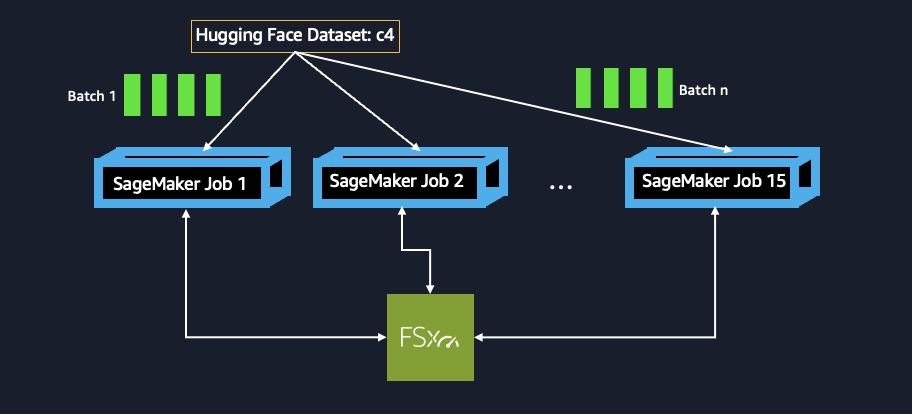

In [ ]:
use_fsx = True

if use_fsx:
    from sagemaker.inputs import FileSystemInput

    file_system_directory_path = "/56uy3bev/c4"
    file_system_access_mode = "rw"
    file_system_type = "FSxLustre"
    train_fs = FileSystemInput(
        file_system_id='fs-0335d20f0f69afd9b',
        file_system_type=file_system_type,
        directory_path=file_system_directory_path,
        file_system_access_mode=file_system_access_mode,
    )
    data_channels = {"train": train_fs}

In [ ]:
data_output_path = "s3://sagemaker-demo-c4/"

base_job_name = f'huggingface-dataset-workertest'

job_names=[]

#len(worker_batches)

for worker_index in range(1):
    current_time = datetime.datetime.now().strftime("%H-%M-%S")

    dataset_job_name = f'{base_job_name}-{worker_index}-{current_time}'

    print(dataset_job_name)

    job_names.append(dataset_job_name)
    
    # hyperparameters, which are passed into the training job
    hyperparameters = {
        "num_proc": 96,
        "split_range": worker_split_range[worker_index],
        "job_name": dataset_job_name,
        "model_id": model_id
    }
    
    # estimator
    estimator = PyTorch(
        entry_point="data.py",
        base_job_name=dataset_job_name,
        max_run=4000,
        role=role,
        framework_version="2.0.1",
        py_version="py310",
        source_dir="./scripts",
        instance_count=1,
        instance_type="ml.m5.24xlarge",
        volume_size=100,
        sagemaker_session=sagemaker_session,
        disable_output_compression=True,
        keep_alive_period_in_seconds=600,
        hyperparameters=hyperparameters,
        output_path=data_output_path,
        subnets=['subnet-0067baa7d7be55e38'],
        security_group_ids=['sg-05ffe325d7d90c501']
    )

    # starting the train job with our uploaded datasets as input
    estimator.fit(inputs=data_channels, wait=True, job_name=dataset_job_name)

    time.sleep(60)
    print("Program resumed after 60 seconds for the next run")

We can started multiple Sagemaker job, with the `.fit()` method passing our FSx file system path to the data script.

In [ ]:
data_output_path = "s3://sagemaker-demo-c4/"

base_job_name = f'huggingface-dataset-workertest'

job_names=[]

#len(worker_split_range)

for worker_index in range(len(worker_split_range)):
    current_time = datetime.datetime.now().strftime("%H-%M-%S")

    dataset_job_name = f'{base_job_name}-{worker_index}-{current_time}'

    print(dataset_job_name)

    job_names.append(dataset_job_name)
    
    # hyperparameters, which are passed into the training job
    hyperparameters = {
        "num_proc": 96,
        "split_range": worker_split_range[worker_index],
        "job_name": dataset_job_name,
        "model_id": model_id
    }
    
    # estimator
    estimator = PyTorch(
        entry_point="data.py",
        base_job_name=dataset_job_name,
        max_run=4000,
        role=role,
        framework_version="2.0.1",
        py_version="py310",
        source_dir="./scripts",
        instance_count=1,
        instance_type="ml.m5.24xlarge",
        volume_size=100,
        sagemaker_session=sagemaker_session,
        disable_output_compression=True,
        keep_alive_period_in_seconds=600,
        hyperparameters=hyperparameters,
        output_path=data_output_path,
        subnets=['subnet-0067baa7d7be55e38'],
        security_group_ids=['sg-05ffe325d7d90c501']
    )

    # starting the train job with our uploaded datasets as input
    estimator.fit(inputs=data_channels, wait=False, job_name=dataset_job_name)

    time.sleep(60)
    print("Program resumed after 60 seconds for the next run")

# Verify the data in FSx using Amazon EC2 

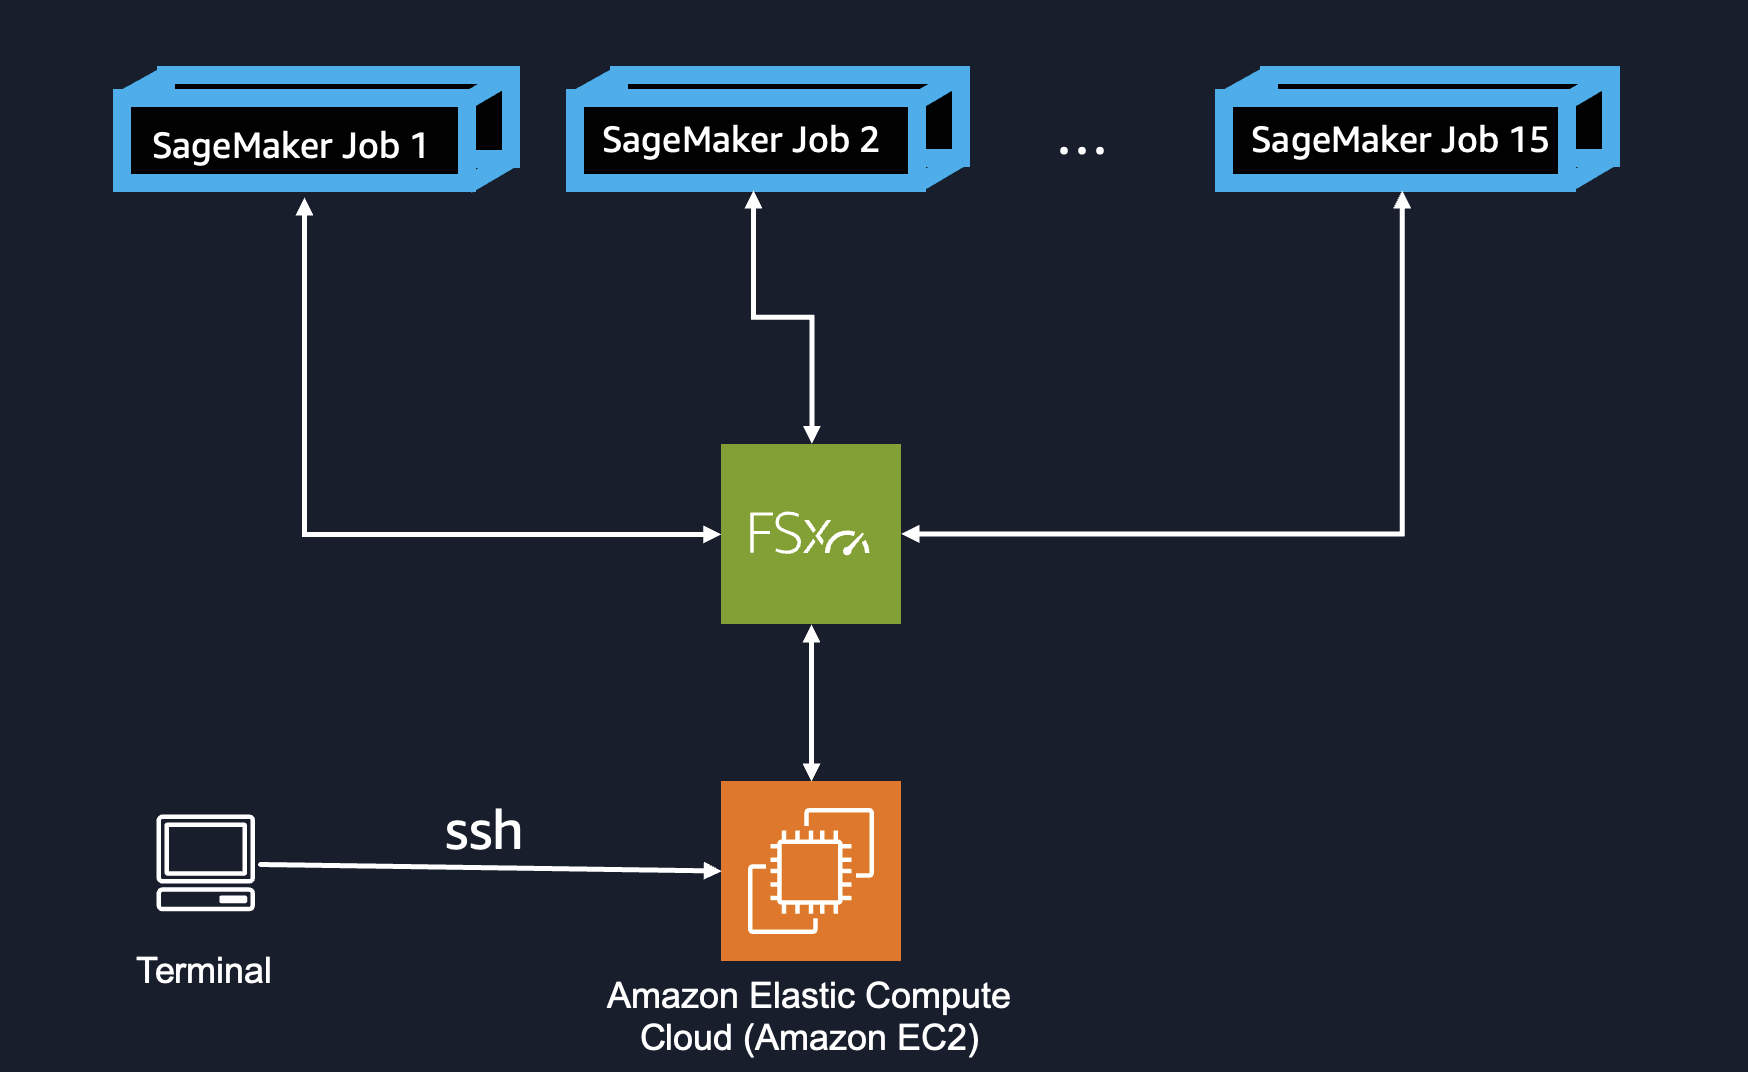

# Run SageMaker training and use FSx as the data channel

In [ ]:
current_time = datetime.datetime.now().strftime("%H-%M-%S")
training_job_name = f"huggingface-training-worker-{current_time}"

# hyperparameters, which are passed into the training job
hyperparameters = {
    "model_id": model_id,  # model id from huggingface.co/models
    "dataset_path": "/opt/ml/input/data/train",  # path where sagemaker will save training dataset
    "valid_path": "/opt/ml/input/data/valid",
    "gradient_checkpointing": True,  # enable gradient checkpointing
    "bf16": True,  # enable mixed precision training
    "optimizer": "adamw_torch",  # optimizer
    "per_device_train_batch_size": 1,  # batch size per device during training
    "epochs": 1,  # number of epochs to train
    "fsdp": '"full_shard auto_wrap"',  # fully sharded data parallelism
    "cache_dir": "/opt/ml/sagemaker/warmpoolcache",  # change this to /tmp if not using warmpools
    "max_steps": 10,
}

# estimator
estimator = PyTorch(
    entry_point="train.py",
    max_run=1800,
    base_job_name=job_name,
    role=role,
    framework_version="2.0.1",
    py_version="py310",
    source_dir="./scripts",
    instance_count=1,
    instance_type="ml.p4d.24xlarge",
    sagemaker_session=sagemaker_session,
    disable_output_compression=True,
    distribution={"torch_distributed": {"enabled": True}},
    keep_alive_period_in_seconds=600,
    hyperparameters=hyperparameters,
    output_path=training_input_path,
    subnets=["subnet-02fa8e3bbd6d5cc5e"],
    security_group_ids=["sg-05ffe325d7d90c501"],
)


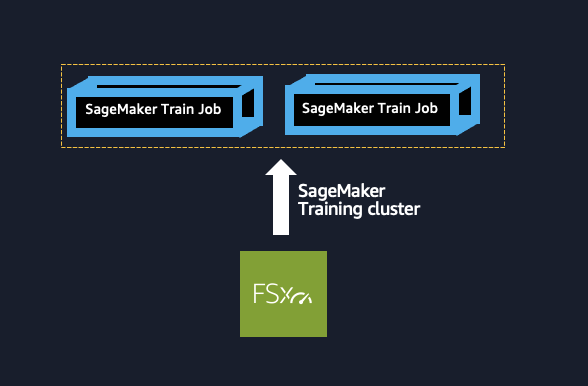

In [ ]:
estimator.fit(inputs=data_channels, wait=True, job_name=training_job_name)

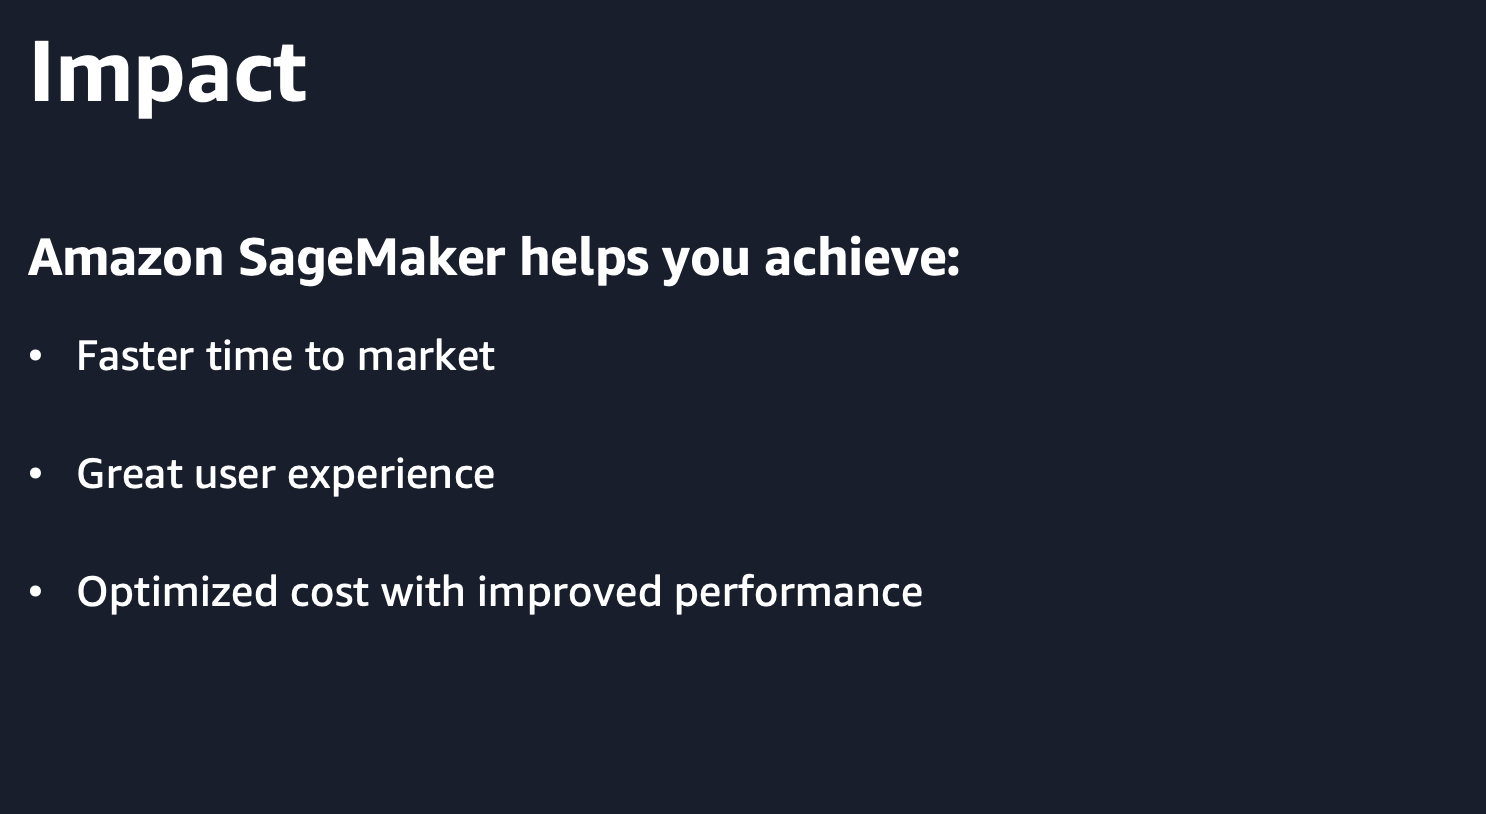